# Density estimation


## Introduction

- Last week we looked a Bayes decision theory
- Nice theoretically, but assumes knowledge about probablity density distribution.
- This is rarely available, so how do we proceed?
- Estimate densities from data!

In this lecture we will cover
- Parametric density estimation
    - Maximum likelihood
- Non-parametric density estimation
    - Histogram approach
    - Parzen window approach

---

## Parametric density estimation

### What do we mean by parametric?

- Assume that the *form* of the probablity density function is known.
- Estimate *parameters* from data

In [12]:
# Generate data from some well known distributions

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform, beta

normal_data = np.random.normal(loc=0, scale=1, size=1000)
uniform_data = np.random.uniform(low=-1, high=1, size=1000)
beta_data = np.random.beta(a=2, b=5, size=1000)
    
x_normal = np.linspace(normal_data.min()-0.1, normal_data.max()+0.1, 100)
p_normal = norm.pdf(x_normal, loc=0, scale=1)

x_uniform = np.linspace(uniform_data.min()-0.1, uniform_data.max()+0.1, 100)
p_uniform = uniform.pdf(x_uniform, loc=-1, scale=2)

x_beta = np.linspace(beta_data.min()-0.1, uniform_data.max()+0.1, 100)
p_beta = beta.pdf(x_beta, a=2, b=5)


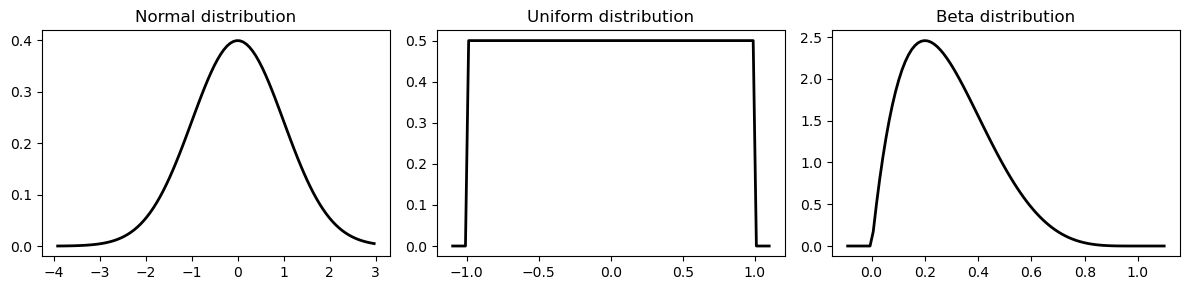

In [13]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.plot(x_normal, p_normal, 'k', linewidth=2, label='PDF')
plt.title('Normal distribution')
plt.subplot(132)
plt.plot(x_uniform, p_uniform, 'k', linewidth=2, label='PDF')
plt.title('Uniform distribution')
plt.subplot(133)
plt.plot(x_beta, p_beta, 'k', linewidth=2, label='PDF')
plt.title('Beta distribution')
plt.tight_layout()
plt.show()

- Recall:
    - Obtain *realizations* from probability density function:
        - $p(\mathbf{x}_1, \boldsymbol{\theta}) \rightarrow \mathbf{x}_1$
        - $p(\mathbf{x}_5, \boldsymbol{\theta}) \rightarrow \mathbf{x}_5$
    - Joint:
        - $p(\mathbf{x}_1, \mathbf{x}_5, \boldsymbol{\theta}) \rightarrow \mathbf{x}_1$ and $\mathbf{x}_5$
    - If independent:
        - $p(\mathbf{x}_1, \mathbf{x}_5, \boldsymbol{\theta}) = p(\mathbf{x}_1, \boldsymbol{\theta})p(\mathbf{x}_5, \boldsymbol{\theta})$

### Likelihood function

- Let $\{\mathbf{x}_1, \cdots, \mathbf{x}_N\}$ and assume independent and identically distributed random variables (i.i.d.).
- Let the set of parameters for a particular distribution form a parameter vector $\boldsymbol{\theta}$.
- The likelihood function of $\boldsymbol{\theta}$ with respect to the random variable $X$ can be expressed as:
    - $p(X; \boldsymbol{\theta})=\prod\limits_{i=1}^N p(\mathbf{x}_i; \boldsymbol{\theta})$
- Idea:
    - Find $\boldsymbol{\theta}$ that makes $X$ most probable.
- Therefore:
    - $\hat{\boldsymbol{\theta}}_{ML} = \underset{\boldsymbol{\theta}}{\operatorname{argmax}}\ p(X; \boldsymbol{\theta})$

In [14]:
# Generate data and illustrate two possible normal distributions based on different parameters

normal_data = np.random.normal(loc=0, scale=1, size=50)

x_normal_good = np.linspace(normal_data.min()-0.1, normal_data.max()+0.1, 100)
p_normal_good = norm.pdf(x_normal_good, loc=0, scale=1)

x_normal_bad = np.linspace(normal_data.min()-0.1, normal_data.max()+3.0, 100)
p_normal_bad = norm.pdf(x_normal_bad, loc=2, scale=1)

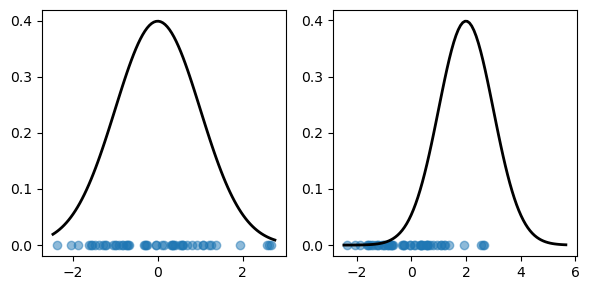

In [15]:
plt.figure(1, figsize=(6,3))
plt.subplot(121)
plt.scatter(normal_data, np.zeros_like(normal_data), alpha=0.5)
plt.plot(x_normal_good, p_normal_good, 'k', linewidth=2, label='PDF')
plt.subplot(122)
plt.scatter(normal_data, np.zeros_like(normal_data), alpha=0.5)
plt.plot(x_normal_bad, p_normal_bad, 'k', linewidth=2, label='PDF')
plt.tight_layout()
plt.show()

### Log-likelihood

- In most cases, we work with the log-likelihood instead of the likelihood itself.
    - Simplifies the mathematics.
    - Can be more numerically stable if we have the product of many small probabilities.
- Log-likelihood:
    - $L(\boldsymbol{\theta}) = \log \prod\limits_{i=1}^N p(\mathbf{x}_i; \boldsymbol{\theta})$
    - Remember: $\log(ab) = \log(a)+\log(b)$
- Want:
    - $\frac{\partial}{\partial \boldsymbol{\theta}} L(\boldsymbol{\theta}) = \mathbf{0}$

### Example with univariate normal

Let us consider the case of a univeriate normal distribution

- Let $\boldsymbol{\theta} = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix} = \begin{bmatrix} \mu \\ \sigma^2 \end{bmatrix}$.
- First - $\log \left[ p(\mathbf{x}_i; \boldsymbol{\theta}) \right]=$
- Then - $\frac{\partial}{\partial \boldsymbol{\theta}}\log \left[ p(\mathbf{x}_i; \boldsymbol{\theta}) \right]=$
- Lastly, asdf


### Example with univariate normal continued

Putting it all together gives us:

- For $\theta_1$:
    - $\hat{\theta}_1 = \hat{\mu} = \frac{1}{N}\sum\limits_{k=1}^N x_k$
- For $\theta_2$:
    - $\hat{\theta}_2 = \hat{\sigma}^2 = \frac{1}{N}\sum\limits_{k=1}^N (x_k-\mu)^2$

Note: In many cases, we will use these estimators for mean and covariances regardless.

## Non-parametric density estimation

- Real-world data rarely follow exact distributions.
- So what do we do when we can find a parametric distribution that matches or data?
- Consider the example below

In [16]:
from ucimlrepo import fetch_ucirepo

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

X = breast_cancer_wisconsin_diagnostic.data.features
X_1_name = 'perimeter'
X_2_name = 'area'


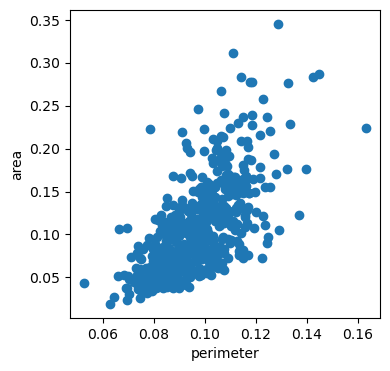

In [17]:
plt.figure(1, figsize=(4, 4))
plt.scatter(X.iloc[:, 4], X.iloc[:, 5])
plt.xlabel(X_1_name)
plt.ylabel(X_2_name)
plt.show()


### Histogram approach

- Idea:
    - Divide input into bins.
    - For each bin; estimate probablity of a sample x being in a bin.
    - This can probability can be estimated using the *frequency ratio*
        - $P \approx k_N / N$, where $N$=total number of samples and $k_N$=number of samples within bin.
    

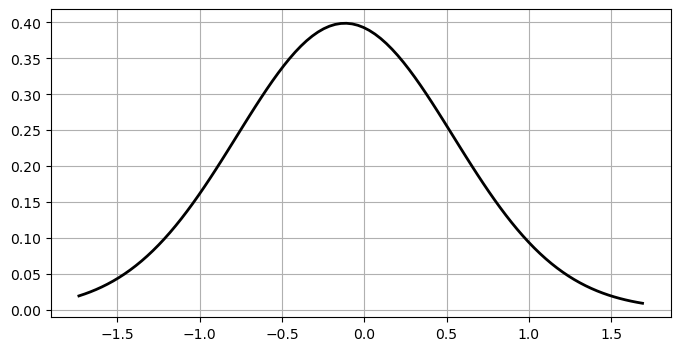

In [20]:
normal_data = np.random.normal(loc=0, scale=1, size=50)
x_normal = np.linspace(normal_data.min()-0.1, normal_data.max()+0.1, 100)
p_normal_good = norm.pdf(x_normal_good, loc=0, scale=1)

plt.figure(1, figsize=(8,4))
plt.plot(x_normal, p_normal_good, 'k', linewidth=2, label='PDF')
plt.grid(True)
plt.show()

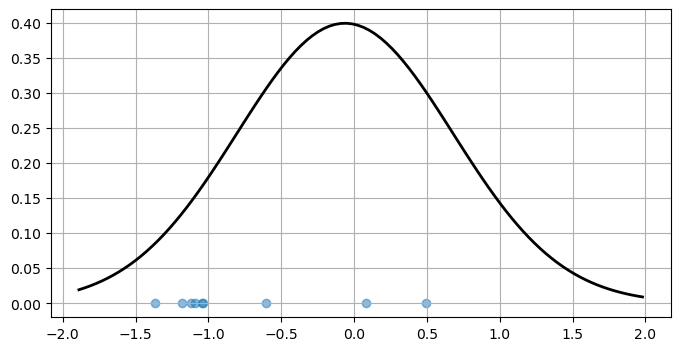

In [23]:
normal_data = np.random.normal(loc=0, scale=1, size=50)
normal_data_example = np.random.normal(loc=0, scale=1, size=9)
x_normal = np.linspace(normal_data.min()-0.1, normal_data.max()+0.1, 100)
p_normal_good = norm.pdf(x_normal_good, loc=0, scale=1)

plt.figure(1, figsize=(8,4))
plt.plot(x_normal, p_normal_good, 'k', linewidth=2, label='PDF')
plt.scatter(normal_data_example, np.zeros_like(normal_data_example), alpha=0.5)
plt.grid(True)
plt.show()

### Alternative histogram approach

- Place bin on each sample.
- Count samples within bin.

### Mathematical formulation of alternative approach

- Define $I(y) = 1$ if $|y|\leq 1/2$

### Problem with histogram approach

- Determining bin size can be difficult, especially for high-dimensional data.
- Not suitable for derivation.
    - "asdf" approximation


## Parzen windows

- Take the alternative histogram approach as a starting point.
- Replace $I$ with a *smooth* function $\phi$
- This gives:
    - asdf
- A typical choice is $N()$
    - then:
- Draw ->


### What to expect from Parzen windows

- Take the alternative histogram approach as a starting point.
- Replace $I$ with a *smooth* function $\phi$
- This gives:
    - asdf
- A typical choice is $N()$
    - then:
- Draw ->


### Remarks

- Plug ...
- Need more d

## Programming exercises

Below are programming exercises assocaited with this lecture. These cell blocks are starting points that loads the data and prepares the problem such that you can get going with the implementation. There are also theoretical exercsies, but due to copyright we cannot shared them here. They will be made available in a private repository connected to the course.


### Problem 2.36 from the book

The cell below generates data from a uniform distribution. Use the Parzen window method to estimate the probability denisty function. Consider the following settings:

- Varying number of samples (32, 256, 5000).
- Use Gaussian kernel for the Parzen windo with a smooting parameters of 0.05 and 0.2.


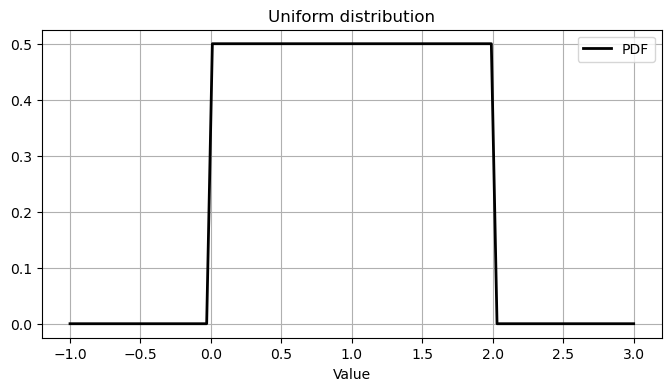

In [13]:
# Visualizing different distributions

number_of_samples = 32
uniform_data = np.random.uniform(low=0, high=2, size=number_of_samples) # for generating data

x_uniform = np.linspace(-1, 3, 100) # for plotting
p_uniform = uniform.pdf(x_uniform, loc=0, scale=2) # for plotting


plt.figure(figsize=(8, 4))
plt.plot(x_uniform, p_uniform, 'k', linewidth=2, label='PDF')
plt.xlabel('Value')
plt.title('Uniform distribution')
plt.legend()
plt.grid(True)
plt.show()

### Problem 2.12 from the book

Below is code that generates the data associated with problem 2.12 from the book. Your task is to:

- Design a Bayesian classifier.
- Design a Bayesian classifier using the following risk parameters. How does this change the decision boundary?
    - $\lambda_{12}$: 1.0
    - $\lambda_{21}$: 0.5
- Experiment with changing the mean and variance of each class. What do you observe?

However, this time you will estimate the probablity density functions. Use both a parametric and non-parametric approach. How do they compare to Bayes classifier?


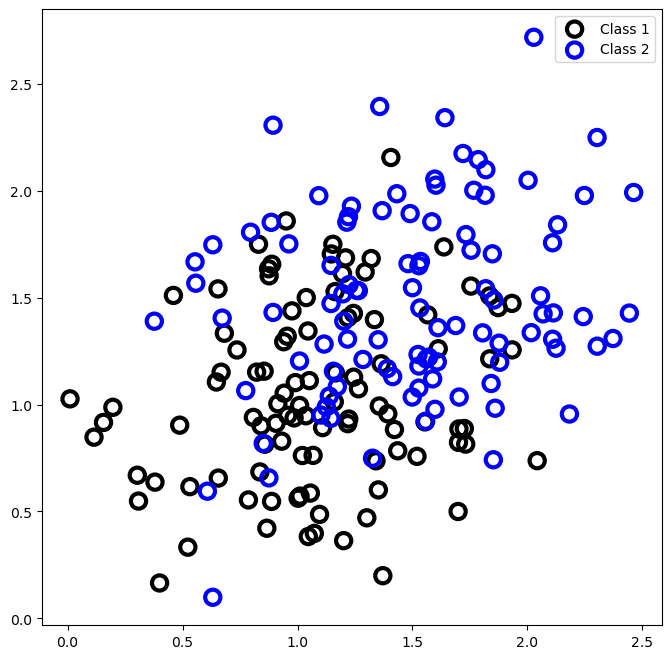

In [17]:
import numpy as np
import matplotlib.pyplot as plt

number_of_samples_in_each_class = 100

mu1 = np.array([1, 1])
mu2 = np.array([1.5, 1.5])
sigma = np.array([[0.2, 0.0], [0.0, 0.2]])

x_train_1 = np.random.multivariate_normal(mu1, sigma, number_of_samples_in_each_class)
x_train_2 = np.random.multivariate_normal(mu2, sigma, number_of_samples_in_each_class)
x_train = np.concatenate((x_train_1, x_train_2))
y_train = np.concatenate((np.ones(number_of_samples_in_each_class), np.zeros(number_of_samples_in_each_class)))

plt.figure(1, figsize=(8, 8))
plt.scatter(x_train_1[:, 0], x_train_1[:, 1], s=120, facecolors='none',
            edgecolors='black', linewidth=3.0, label='Class 1')
plt.scatter(x_train_2[:, 0], x_train_2[:, 1], s=120, facecolors='none',
            edgecolors='blue', linewidth=3.0, label='Class 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

### Classification using Bayes classifiers and density estimation

You will now get your first experince working with real-world data. Below is a code block that loads the Iris dataset, one of the earliest known datasets used for evaluating classification methods and a classic introductory dataset in pattern recognition and machine learning. [See here for more information about the dataset](https://archive.ics.uci.edu/dataset/53/iris).

The data is 4-dimensional with 3 classes. Here, we have simplifed the problem a bit and extracted 2 features such that the dataset can be easily visualized. Use the density estimation approach you deem the most suitable and combine it with a Bayesian classifier to tackle the problem of Iris plant classification.


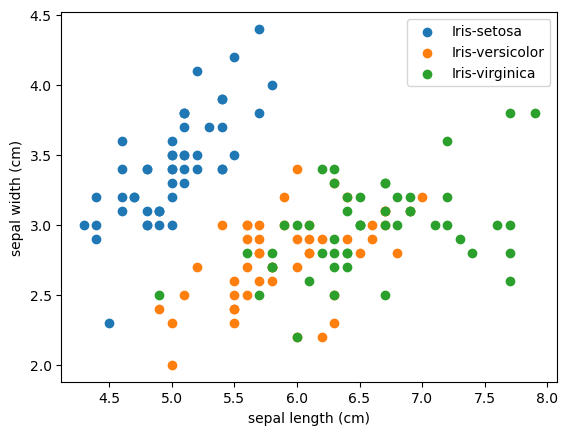

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features.iloc[:, :2]
feature_1_name = 'sepal length (cm)'
feature_2_name = 'sepal width (cm)'
y = np.zeros(150)
y[50:100] = 1
y[100:150] = 2
y_names = np.unique(iris.data.targets)


plt.figure(1)
for class_i, class_name in enumerate(y_names):
    plt.scatter(X.iloc[np.where(y == class_i)[0], 0], X.iloc[np.where(y == class_i)[0], 1], label=class_name)
plt.xlabel(feature_1_name)
plt.ylabel(feature_2_name)
plt.legend()
plt.show()
